In [74]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image


In [1]:
import os
import numpy as np
import random
import pandas as pd

class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [2]:
class InHospitalMortalityReader(Reader):
    def __init__(self, dataset_dir, listfile=None, period_length=48.0):
        """ Reader for in-hospital moratality prediction task.

        :param dataset_dir:   Directory where timeseries files are stored.
        :param listfile:      Path to a listfile. If this parameter is left `None` then
                              `dataset_dir/listfile.csv` will be used.
        :param period_length: Length of the period (in hours) from which the prediction is done.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(x, int(y)) for (x, y) in self._data]
        self._period_length = period_length

    def _read_timeseries(self, ts_filename):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : int (0 or 1)
                In-hospital mortality.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._period_length
        y = self._data[index][1]
        (X, header) = self._read_timeseries(name)

        return {"X": X,
                "t": t,
                "y": y,
                "header": header,
                "name": name}


In [3]:
dataset_dir = "C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\in-hospital-mortality"
root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [4]:
train_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                         listfile=os.path.join(dataset_dir, 'train_listfile.csv'),
                                         period_length=48.0)


val_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                       listfile=os.path.join(dataset_dir, 'val_listfile.csv'),
                                       period_length=48.0)

test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'test'),
                                       listfile=os.path.join(dataset_dir, 'test_listfile.csv'),
                                       period_length=48.0)

In [5]:
global_category_mapping = {
  'Glascow coma scale eye opening': {'': 0,
  'To Pain': 1,
  'None': 2,
  'Spontaneously': 3,
  'To Speech': 4,
  '4 Spontaneously': 5,
  '1 No Response': 6,
  '2 To pain': 7,
  '3 To speech': 8},
 'Glascow coma scale motor response': {'': 0,
  'Localizes Pain': 1,
  '3 Abnorm flexion': 2,
  'Abnormal extension': 3,
  '5 Localizes Pain': 4,
  '6 Obeys Commands': 5,
  'Flex-withdraws': 6,
  '2 Abnorm extensn': 7,
  'Obeys Commands': 8,
  'Abnormal Flexion': 9,
  'No response': 10,
  '4 Flex-withdraws': 11,
  '1 No Response': 12},
 'Glascow coma scale verbal response': {'': 0,
  'Inappropriate Words': 1,
  'Incomprehensible sounds': 2,
  'Oriented': 3,
  '2 Incomp sounds': 4,
  '4 Confused': 5,
  'No Response-ETT': 6,
  '3 Inapprop words': 7,
  'Confused': 8,
  'No Response': 9,
  '1.0 ET/Trach': 10,
  '5 Oriented': 11,
  '1 No Response': 12}}

In [6]:
import numpy as np
import pandas as pd

TIME_WINDOWS = [(0, '25%'), (0, '50%'), ('75%','100%'), (0, '100%')]

CHANNELS = {
    'Diastolic blood pressure': 'numerical',
    'Fraction inspired oxygen': 'numerical',
    'Glascow coma scale eye opening': 'categorical',
    'Glascow coma scale motor response': 'categorical',
    'Glascow coma scale total': 'numerical',
    'Glascow coma scale verbal response': 'categorical',
    'Glucose': 'numerical',
    'Heart Rate': 'numerical',
    'Mean blood pressure': 'numerical',
    'Oxygen saturation': 'numerical',
    'Respiratory rate': 'numerical',
    'Systolic blood pressure': 'numerical',
    'Temperature': 'numerical',
    'Weight': 'numerical'
}

admission_mapping = {'UNKNOWN': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'URGENT': 3}
dbsource_mapping = {'carevue': 1, 'metavision': 2, 'both': 3}
icu_unit_mapping = {'MICU': 1, 'CCU': 2, 'TSICU': 3, 'SICU': 4, 'CSRU': 5}

def extract_features_from_reader(train_reader, index, root):
     # Read the example data from the reader
    example_data = train_reader.read_example(index)
    ts_data = pd.DataFrame(data=example_data['X'], columns=example_data['header'])
    
#     Replace empty strings with NaN
#     ts_data = ts_data.replace('', np.nan)
    
#     # Forward fill to carry forward the last known value
#     ts_data = ts_data.fillna(method='ffill')
    
#     # Backward fill to fill any remaining NaNs
#     ts_data = ts_data.fillna(method='bfill')
    
#     # If there are still any NaNs, fill them with 0
#     ts_data = ts_data.fillna(0)
#     ts_data = ts_data.apply(pd.to_numeric, errors='coerce')
    ts_data['Hours'] = ts_data['Hours'].astype(float)
    
    all_features = []
    all_categorical_features = []
    labels = []
    for start_hour, end_hour in TIME_WINDOWS:
        # Determine the end_hour for percentage-based windows
        if isinstance(start_hour, str):
            start_hour = ts_data['Hours'].quantile(0.75)
        if isinstance(end_hour, str):
            end_hour = ts_data['Hours'].max()
#             total_hours = ts_data['Hours'].max()
#             end_hour = total_hours * float(end_hour.strip('%')) / 100.0
        

        
        # Filter the data for the current time window
        ts_window_data = ts_data[(ts_data['Hours'] >= start_hour) & (ts_data['Hours'] <= end_hour)]
        ts_window_data_num = ts_window_data.apply(pd.to_numeric, errors='coerce')
        features = []
        for channel, channel_type in CHANNELS.items():
            if channel_type == 'numerical'and channel in list(CHANNELS.keys()):
                # Debug: Check if mean_value is NaN

                # Extract statistics for numerical channels
                features.append(ts_window_data_num[channel].mean())
                features.append(ts_window_data_num[channel].std())
                features.append(ts_window_data_num[channel].min())
                features.append(ts_window_data_num[channel].max())
                features.append(ts_window_data_num[channel].skew())
#                 features.append(ts_window_data[channel].iloc[-1] if not ts_window_data[channel].empty else np.nan)
                features.append(len(ts_window_data_num[channel]))
                features.append(ts_window_data_num[channel].quantile(0.25))
                features.append(ts_window_data_num[channel].quantile(0.75))
                features.append(ts_window_data_num[channel].quantile(0.75) - ts_window_data_num[channel].quantile(0.25))
                
                
            if channel_type == 'categorical':
                # Get the value counts
                value_counts = ts_window_data[channel].value_counts()

                # Find the most frequent non-empty category
                most_frequent_category = ''
                for category in value_counts.index:
                    if category != '':
                        most_frequent_category = category
                        break

                # If no non-empty category is found, default to zero
                if most_frequent_category == '':
                    mapped_value = 0
                else:
                    # Map it to its numerical value
                    mapped_value = global_category_mapping[channel].get(most_frequent_category, 0)

                # Append it to the categorical features list
                all_categorical_features.append(mapped_value)
                
        all_features.extend(features)
    all_features =  np.array(all_features)
    all_features = np.nan_to_num(all_features)
    # Convert categorical features list to NumPy array and append it to all_features
    all_categorical_features = np.array(all_categorical_features)
    
    # Extract the patient ID and episode number from the file name
    file_name = example_data['name']
    patient_id, episode_num = file_name.split('_')[0], file_name.split('_')[1].replace('episode', '')
    
    # Define the root directory and train folder
    if root == 'train':
        train_dir = os.path.join(root_dir, 'train')
    elif root == 'test':
        train_dir = os.path.join(root_dir, 'test')
    
    # Load the combined data
    combined_data = pd.read_csv('combined_data')
    
    # Access the patient folder
    patient_path = os.path.join(train_dir, patient_id)
    
    # Load the stays data
    stays_data = pd.read_csv(os.path.join(patient_path, 'stays.csv'))
    
    # Access the episode folder
    #episode_path = os.path.join(patient_path, f'episode{episode_num}')
    
    # Load the episode data
    episode_data = pd.read_csv(os.path.join(patient_path, f'episode{episode_num}.csv'))
    
    # Extract the relevant features
    age = episode_data['Age'].values[0]
    weight = episode_data['Weight'].values[0]
    ethnicity = episode_data['Ethnicity'].values[0]
    gender = episode_data['Gender'].values[0]
    dbsource = stays_data['DBSOURCE'].values[0]
    last_careunit = stays_data['LAST_CAREUNIT'].values[0]
    
    # Get the admission type from the combined data
    # Get the admission type from the combined data
    icustay_id = stays_data['ICUSTAY_ID'].values[0]
    matching_rows = combined_data[combined_data['ICUSTAY_ID'] == icustay_id]

    if not matching_rows.empty:
        admission_type = matching_rows['ADMISSION_TYPE'].values[0]
    else:
        # Handle the case where there are no matching rows
        print(f"No matching rows found for ICUSTAY_ID {icustay_id}")
        admission_type = "UNKNOWN"

    
    # Map the categorical variables to their numerical representations
    mapped_admission_type = admission_mapping.get(admission_type, 0)  # Default to 0 if not found
    mapped_dbsource = dbsource_mapping.get(dbsource, 0)  # Default to 0 if not found
    mapped_last_careunit = icu_unit_mapping.get(last_careunit, 0)  # Default to 0 if not found

    # Create the static data vector with the mapped values
    static_data_vector = [age, weight, gender, ethnicity, mapped_dbsource, mapped_last_careunit, mapped_admission_type]

    
    all_features = np.concatenate((all_features, all_categorical_features,static_data_vector))
    
    labels.append(example_data['y'])
    
    return all_features, labels 
# Example usage
# all_features = extract_features_from_reader(train_reader, 0)


In [7]:
train_features = []
train_labels = []
for i in range(train_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(train_reader, i,'train')
    train_features.append(all_features)
    train_labels.append(label)

No matching rows found for ICUSTAY_ID 283217


In [8]:
val_features = []
val_labels = []
for i in range(val_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(val_reader, i,'train')
    val_features.append(all_features)
    val_labels.append(label)

In [9]:
test_features = []
test_labels = []
for i in range(test_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(test_reader, i,'test')
    test_features.append(all_features)
    test_labels.append(label)

In [13]:
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

In [17]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [20]:
# Define the indices of the categorical features
categorical_indices = list(range(495, 511)) + list(range(512, 518))

# Define the indices of the numerical features
numerical_indices = [i for i in range(train_features.shape[1]) if i not in categorical_indices]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both
train_features[:, numerical_indices] = scaler.fit_transform(train_features[:, numerical_indices])

# Use the same scaler to transform the validation and test data
val_features[:, numerical_indices] = scaler.transform(val_features[:, numerical_indices])
test_features[:, numerical_indices] = scaler.transform(test_features[:, numerical_indices])


In [24]:
train_labels = train_labels.reshape(-1)
val_labels = val_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

In [143]:
train_features.shape

(14681, 517)

In [35]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(train_features)
X_val = imputer.transform(val_features)
X_test = imputer.transform(test_features)

In [142]:
np.save('X_train_m.npy',X_train)
np.save('X_val_m.npy',X_val)
np.save('X_test_m.npy',X_test)
np.save('train_labels_m',train_labels)
np.save('val_labels_m',val_labels)
np.save('test_labels_m',test_labels)

In [43]:
X_train[0]

array([ 7.36223229e-02,  3.21351386e-03, -8.99280581e-01,  6.35226082e-03,
       -1.53755018e+00,  1.34863121e+00,  9.90199911e-01,  1.23051643e+00,
        9.27531969e-01, -5.26649052e-01, -3.33091707e-01, -5.15366459e-01,
       -5.20911857e-01, -1.09467698e-01,  1.34863121e+00, -5.20692172e-01,
       -5.24174332e-01, -3.18808951e-01,  1.49086219e+00, -3.36509883e-01,
        1.55651851e+00,  1.40188148e+00,  2.00070235e-02,  1.34863121e+00,
        1.52451235e+00,  1.44683840e+00, -3.24499937e-01,  2.93621228e+00,
        1.13461303e+00,  2.95961947e+00,  2.09000917e+00, -8.01466773e-02,
        1.34863121e+00,  3.02777215e+00,  2.96000764e+00,  1.19314129e+00,
        1.95653449e+00,  7.65394154e-01,  1.16786901e+00,  1.93624034e+00,
       -7.30766554e-01,  1.34863121e+00,  1.90735516e+00,  2.02610484e+00,
        9.29024290e-01,  7.14169954e-01,  3.54719030e-01, -1.00523309e+00,
        2.97355995e-01, -1.54196972e+00,  1.34863121e+00,  7.62698792e-01,
        9.63114386e-01,  

In [36]:
import numpy as np

# Assume your_array is the array you want to check
num_nan = np.isnan(X_train).sum()

print(f"Total number of NaN values in the array: {num_nan}")



Total number of NaN values in the array: 0


In [139]:
model = LogisticRegression(penalty = 'l2',C = 0.2, class_weight = 'balanced', max_iter = 1000)
model.fit(X_train, train_labels)

C:\Users\samit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.2, class_weight='balanced', max_iter=1000)

In [140]:
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [141]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming y_val_true and y_test_true are your ground truth labels for validation and test sets respectively
# and y_val_pred and y_test_pred are the predicted labels from your model for validation and test sets respectively

# Validation metrics
val_accuracy = accuracy_score(val_labels, y_val_pred)
val_precision = precision_score(val_labels, y_val_pred)
val_recall = recall_score(val_labels, y_val_pred)
val_f1 = f1_score(val_labels, y_val_pred)
val_roc_auc = roc_auc_score(val_labels, y_val_pred)

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1 Score: {val_f1}")
print(f"ROC AUC: {val_roc_auc}")

# Test metrics
test_accuracy = accuracy_score(test_labels, y_test_pred)
test_precision = precision_score(test_labels, y_test_pred)
test_recall = recall_score(test_labels, y_test_pred)
test_f1 = f1_score(test_labels, y_test_pred)
test_roc_auc = roc_auc_score(test_labels, y_test_pred)

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC: {test_roc_auc}")


Validation Metrics:
Accuracy: 0.7194289261328367
Precision: 0.2804878048780488
Recall: 0.6857798165137615
F1 Score: 0.39813581890812255
ROC AUC: 0.7052373598003122

Test Metrics:
Accuracy: 0.7178615574783683
Precision: 0.24836601307189543
Recall: 0.7112299465240641
F1 Score: 0.3681660899653979
ROC AUC: 0.7149790543242265


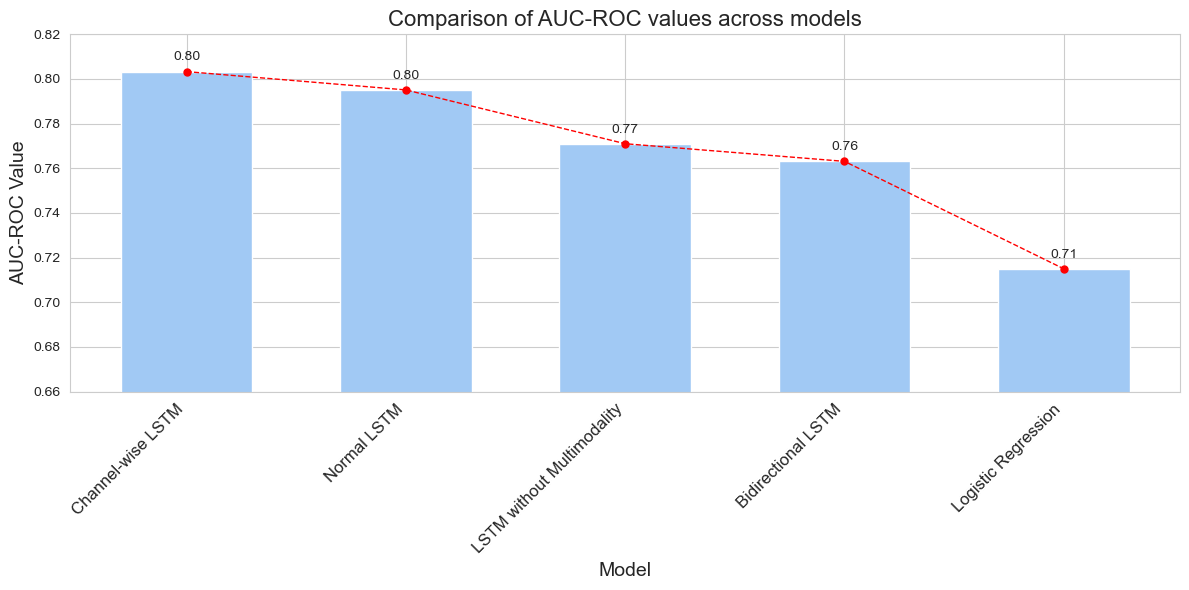

In [148]:
# Model names and AUC-ROC values
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
model_names = ["Logistic Regression","Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]
micro_auc_values = [0.7149790543242265,0.7951, 0.7631, 0.771, 0.8033]
macro_auc_values = [0.624014295026788,0.65,0.64,0.66,0.64]

# Combine the data and sort by Micro and Macro AUC-ROC values
data_micro = list(zip(model_names, micro_auc_values))
data_macro = list(zip(model_names, macro_auc_values))

data_micro.sort(key=lambda x: x[1], reverse=True)
data_macro.sort(key=lambda x: x[1], reverse=True)

sorted_model_names_micro, sorted_micro_auc = zip(*data_micro)
sorted_model_names_macro, sorted_macro_auc = zip(*data_macro)

# Set up the bar positions
bar_width = 0.6
index = np.arange(len(model_names))

# Create the bars
sns.set_style("whitegrid")

# Plot for Micro AUC-ROC
plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, sorted_micro_auc, bar_width,  color=sns.color_palette("pastel")[0], label='Micro AUC-ROC')
plt.xlabel('Model', fontsize=14)
plt.ylabel('AUC-ROC Value', fontsize=14)
plt.title('Comparison of AUC-ROC values across models', fontsize=16)
plt.xticks(index, sorted_model_names_micro, rotation=45, ha='right', fontsize=12)
plt.ylim(0.66, 0.82)
plt.plot(index, sorted_micro_auc, color='red', marker='o', linestyle='dashed', linewidth=1, markersize=5)
for i, v in enumerate(sorted_micro_auc):
    plt.text(i, v + 0.005, "{:.2f}".format(v), ha='center')
plt.tight_layout()
plt.show()


In [48]:
rf = RandomForestClassifier()
rf.fit(X_train, train_labels)

RandomForestClassifier()

In [49]:
y_pred_r = rf.predict(X_test)

In [50]:
test_roc_auc_rf = roc_auc_score(test_labels, y_pred_r)

In [51]:
print(test_roc_auc_rf)

0.56648803985097


In [52]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020A9236F3A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020A923519A0>})

In [53]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 226}


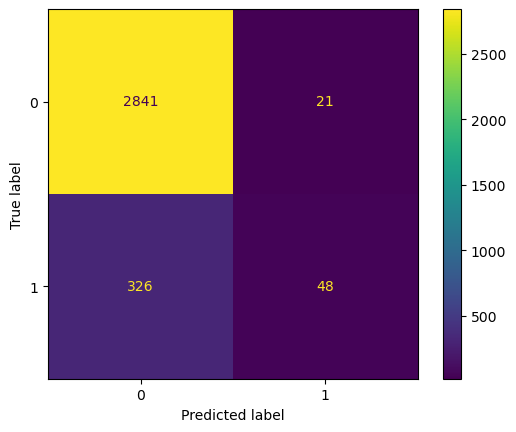

In [54]:
y_pred_cv = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred_cv)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [55]:
test_roc_auc_cv = roc_auc_score(test_labels, y_pred_cv)

In [56]:
print(test_roc_auc_cv)

0.5605023598919271


In [203]:
all_features, label = extract_features_from_reader(train_reader, 0,'train')

In [204]:
len(all_features)

517

In [205]:
all_features

array([ 7.62142857e+01,  1.55690984e+01,  3.40000000e+01,  9.80000000e+01,
       -1.26809674e+00,  3.10000000e+01,  7.07500000e+01,  8.60000000e+01,
        1.52500000e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.10000000e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.50000000e+01,  0.00000000e+00,
        1.50000000e+01,  1.50000000e+01,  0.00000000e+00,  3.10000000e+01,
        1.50000000e+01,  1.50000000e+01,  0.00000000e+00,  3.94000000e+02,
        7.21248917e+01,  3.43000000e+02,  4.45000000e+02,  0.00000000e+00,
        3.10000000e+01,  3.68500000e+02,  4.19500000e+02,  5.10000000e+01,
        1.31500000e+02,  1.09865237e+01,  1.03000000e+02,  1.50000000e+02,
       -5.11255331e-01,  3.10000000e+01,  1.25250000e+02,  1.39000000e+02,
        1.37500000e+01,  9.09404392e+01,  1.70404881e+01,  4.33333015e+01,
        1.11000000e+02, -1.34440588e+00,  3.10000000e+01,  8.49166756e+01,
        1.01333000e+02,  

In [178]:
label

[1]

In [185]:
total_features = []
train_labels = []
for i in range(train_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(train_reader, i,'train')
    total_features.append(all_features)
    train_labels.append(label)

In [208]:
from sklearn.preprocessing import StandardScaler
import numpy as np
X = np.array(total_features)
# Define the indices of the categorical features
categorical_indices = list(range(495, 511)) + list(range(512, 518))

# Define the indices of the numerical features
numerical_indices = [i for i in range(X.shape[1]) if i not in categorical_indices]

# Extract the numerical features
X_numerical = X[:, numerical_indices]

# Normalize the numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(X_numerical)

# Put the normalized features back into the original array
X[:, numerical_indices] = X_numerical


In [211]:
X[0]

array([ 1.22152336e+00,  1.17780468e+00, -1.14530508e+00,  1.21141541e+00,
       -1.36742689e+00,  2.06641449e+00,  1.19984592e+00,  1.46425324e+00,
        7.79002235e-01, -4.94761658e-01, -3.27982535e-01, -4.83838510e-01,
       -4.87630583e-01, -1.56549384e-01,  2.06641449e+00, -4.88999613e-01,
       -4.91718271e-01, -3.05940340e-01,  1.29800733e+00, -3.68092336e-01,
        1.35564950e+00,  1.22663020e+00,  3.23126479e-02,  2.06641449e+00,
        1.32495878e+00,  1.26193882e+00, -3.03203217e-01,  2.87298087e+00,
        1.31220108e+00,  2.65268973e+00,  2.11312305e+00, -7.18865824e-02,
        2.06641449e+00,  2.83110339e+00,  3.04819383e+00,  1.84571091e+00,
        2.29274292e+00,  7.47633324e-01,  1.29020979e+00,  2.29295634e+00,
       -6.51008386e-01,  2.06641449e+00,  2.14577202e+00,  2.36357608e+00,
        6.39098445e-01,  9.34476226e-01,  1.11158196e+00, -1.14645791e+00,
        8.19012820e-01, -1.61289961e+00,  2.06641449e+00,  9.48300886e-01,
        1.20242900e+00,  

In [194]:
labels_2d = np.array(train_labels)
labels_1d = labels_2d.reshape(-1)

In [197]:
labels_1d

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [184]:
train_reader.get_number_of_examples()

14681

In [189]:
example = train_reader.read_example(1)

In [191]:
lis = []

lis.append(example['y'])

In [192]:
lis

[0]